# 6.1 RNN의 문제점

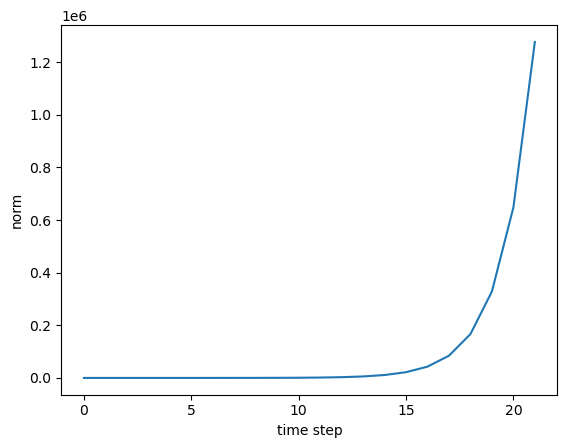

In [1]:
import numpy as np
import matplotlib.pyplot as plt

N, H, T = 2, 3, 22
dh = np.ones((N,H))
np.random.seed(22)
Wh = np.random.randn(H,H)

norm_list = []
for t in range(T):
    dh = np.matmul(dh, Wh.T)
    norm = np.sqrt(np.sum(dh**2)) / N
    norm_list.append(norm)
    
plt.plot(norm_list, linestyle='-')
plt.xlabel('time step')
plt.ylabel('norm')
plt.show()

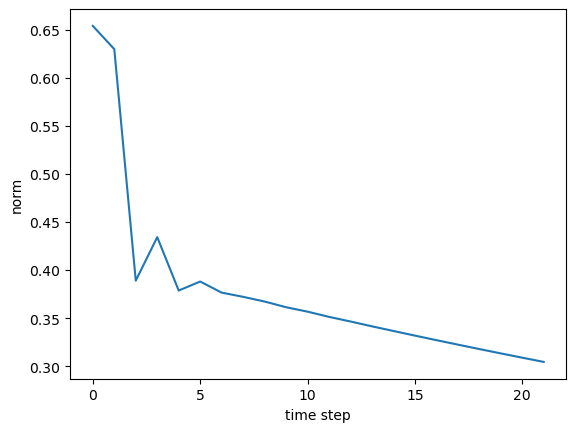

In [2]:
N, H, T = 2, 3, 22
dh = np.ones((N,H))
np.random.seed(22)
Wh = np.random.randn(H,H) * 0.5

norm_list = []
for t in range(T):
    dh = np.matmul(dh, Wh.T)
    norm = np.sqrt(np.sum(dh**2)) / N
    norm_list.append(norm)
    
plt.plot(norm_list, linestyle='-')
plt.xlabel('time step')
plt.ylabel('norm')
plt.show()

In [3]:
dW1 = np.random.rand(3,3) * 10
dW2 = np.random.rand(3,3) * 10
grads = [dW1, dW2]
max_norm = 5.

def clip_grads(grads, max_norm):
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad **2)
    total_norm = np.sqrt(total_norm)
    
    rate = max_norm / (total_num + 1e-6)
    if rate<1:
        for grad in grads:
            grad *= rate

# 6.2 기울기 소실과 LSTM

# 6.3 LSTM 구현

In [4]:
class LSTM:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx),np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None
    
    def forward(self, x, h_prev, c_prev):
        Wx, Wh, b = self.params
        N, H = h_prev.shape
        
        A = np.matmul(x, Wx) + np.matmul(h_prev, Wh) + b
        
        f = A[:, :H]
        g = A[:, H:2*H]
        i = A[:, 2*H:3*H]
        o = A[:, 3*H:]
        
        f = sigmoid(f)
        g = np.tang(g)
        i = sigmoid(i)
        o = sigmoid(o)
        
        c_next = f * c_prev + g *i
        h_next = o * np.tanh(c_next)
        
        self.cache = (x, h_prev, c_prev, i, f, g, o, c_next)
        return h_next, c_next

In [5]:
class TimeLSTM:
    def __Init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None
        self.h, self.c = None, None
        self.dh = None
        self.stateful = stateful
        
    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shpae
        H = Wh.state[0]
        
        self.layers = []
        hs = np.empty((N, T, M), dtype='f')
        
        if not self.stateful or self.h is None:
            self.h = np.zeros((N,H), dtype = 'f')
        if not self.stateful or self.c is None:
            self.c = np.zeros((N,H), dtype = 'f')
        
        for t in range(T):
            layer = LSTM(*self.params)
            self.h, self.c = layer.forward(xs[:, t,:], self.h, self.c)
            hs[:, t, :] = self.h
            
            self.layer.append(layer)
            
        return hs
    
    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D = Wx.shape[0]
        
        dxs = np.empty((N, T, D), dtype='f')
        dh,dc = 0,0
        
        grads = [0,0,0]
        for t in reversed(range(T)):
            laye = self.layers[t]
            dx, dh, dc = layer.backward(dhs[:,t,:] + dh, dc)
            dxs[:, t,:] = dx
            for i, grad in enumerate(layer.grads):
                grads[i] +=grad
                
        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
            
        self.dh = dh
        return dxs
    
    def set_state(self, h, c = None):
        self.h, self.c = h,c
        
    def reset_state(self):
        self.h, self.c = None, None

# LSTM을 사용한 언어 모델

In [6]:
import sys
sys.path.append('..')
from common.time_layers import *
import pickle


class Rnnlm:
    def __init__(self, vocab_size=10000, wordvec_size=100, hidden_size=100):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.layers = [
            TimeEmbedding(embed_W),
            TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layer = self.layers[1]

        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, xs):
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs

    def forward(self, xs, ts):
        score = self.predict(xs)
        loss = self.loss_layer.forward(score, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        self.lstm_layer.reset_state()
    
    def save_params(self, file_name = 'Rnnlm.pkl'):
        with open(file_name, 'wb') as f:
            pickle.dump(self.params, f)
    
    def load_params(self, file_name = 'Rnnlm.pkl'):
        with open(file_name, 'rb') as f: 
            self.params = pickle.load(f)

| epoch 1 |  iter 1 / 1327 | time 0[s] | perplexity 9999.65
| epoch 1 |  iter 21 / 1327 | time 2[s] | perplexity 2741.07
| epoch 1 |  iter 41 / 1327 | time 10[s] | perplexity 1259.61
| epoch 1 |  iter 61 / 1327 | time 18[s] | perplexity 966.02
| epoch 1 |  iter 81 / 1327 | time 26[s] | perplexity 770.14
| epoch 1 |  iter 101 / 1327 | time 34[s] | perplexity 661.05
| epoch 1 |  iter 121 / 1327 | time 42[s] | perplexity 634.52
| epoch 1 |  iter 141 / 1327 | time 50[s] | perplexity 591.18
| epoch 1 |  iter 161 / 1327 | time 59[s] | perplexity 573.59
| epoch 1 |  iter 181 / 1327 | time 67[s] | perplexity 581.16
| epoch 1 |  iter 201 / 1327 | time 75[s] | perplexity 498.81
| epoch 1 |  iter 221 / 1327 | time 83[s] | perplexity 494.12
| epoch 1 |  iter 241 / 1327 | time 91[s] | perplexity 438.73
| epoch 1 |  iter 261 / 1327 | time 100[s] | perplexity 465.73
| epoch 1 |  iter 281 / 1327 | time 108[s] | perplexity 449.97
| epoch 1 |  iter 301 / 1327 | time 116[s] | perplexity 398.06
| epoch 1 

| epoch 2 |  iter 1261 / 1327 | time 1048[s] | perplexity 121.63
| epoch 2 |  iter 1281 / 1327 | time 1056[s] | perplexity 122.18
| epoch 2 |  iter 1301 / 1327 | time 1064[s] | perplexity 157.14
| epoch 2 |  iter 1321 / 1327 | time 1072[s] | perplexity 153.02
| epoch 3 |  iter 1 / 1327 | time 1074[s] | perplexity 160.23
| epoch 3 |  iter 21 / 1327 | time 1083[s] | perplexity 144.40
| epoch 3 |  iter 41 / 1327 | time 1093[s] | perplexity 135.32
| epoch 3 |  iter 61 / 1327 | time 1102[s] | perplexity 128.54
| epoch 3 |  iter 81 / 1327 | time 1112[s] | perplexity 116.01
| epoch 3 |  iter 101 / 1327 | time 1121[s] | perplexity 105.21
| epoch 3 |  iter 121 / 1327 | time 1129[s] | perplexity 115.78
| epoch 3 |  iter 141 / 1327 | time 1137[s] | perplexity 125.13
| epoch 3 |  iter 161 / 1327 | time 1145[s] | perplexity 142.01
| epoch 3 |  iter 181 / 1327 | time 1153[s] | perplexity 149.03
| epoch 3 |  iter 201 / 1327 | time 1161[s] | perplexity 140.75
| epoch 3 |  iter 221 / 1327 | time 1169[s

| epoch 4 |  iter 1161 / 1327 | time 2114[s] | perplexity 89.89
| epoch 4 |  iter 1181 / 1327 | time 2122[s] | perplexity 95.62
| epoch 4 |  iter 1201 / 1327 | time 2130[s] | perplexity 83.01
| epoch 4 |  iter 1221 / 1327 | time 2138[s] | perplexity 75.16
| epoch 4 |  iter 1241 / 1327 | time 2147[s] | perplexity 90.87
| epoch 4 |  iter 1261 / 1327 | time 2154[s] | perplexity 92.78
| epoch 4 |  iter 1281 / 1327 | time 2162[s] | perplexity 88.47
| epoch 4 |  iter 1301 / 1327 | time 2171[s] | perplexity 111.27
| epoch 4 |  iter 1321 / 1327 | time 2179[s] | perplexity 108.97


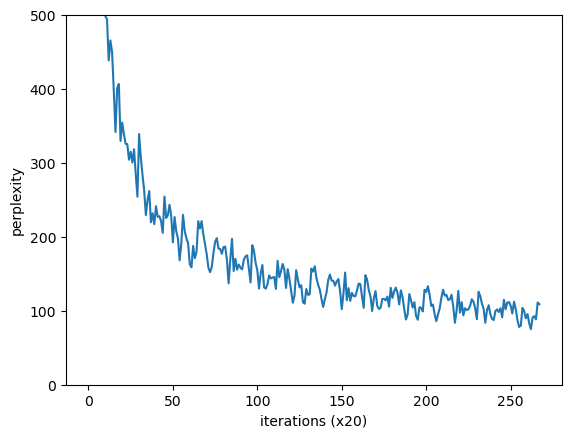

evaluating perplexity ...
234 / 235
test perplexity:  135.08886030418785


In [7]:
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity
from dataset import ptb

batch_size = 20
wordvec_size = 100
hidden_size = 100
time_size = 35
lr = 20.0
max_epoch = 4
max_grad = 0.25

corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_test, _, _ = ptb.load_data('test')
vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

model = Rnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad,
            eval_interval=20)
trainer.plot(ylim=(0, 500))

model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('test perplexity: ', ppl_test)

model.save_params()

# RNN 추가 개선

In [8]:
import sys
sys.path.append('..')
from common.time_layers import *
from common.np import *
from common.base_model import BaseModel


class BetterRnnlm(BaseModel):
    
    def __init__(self, vocab_size=10000, wordvec_size=650,
                 hidden_size=650, dropout_ratio=0.5):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx1 = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh1 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b1 = np.zeros(4 * H).astype('f')
        lstm_Wx2 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_Wh2 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b2 = np.zeros(4 * H).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.layers = [
            TimeEmbedding(embed_W),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx1, lstm_Wh1, lstm_b1, stateful=True),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx2, lstm_Wh2, lstm_b2, stateful=True),
            TimeDropout(dropout_ratio),
            TimeAffine(embed_W.T, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layers = [self.layers[2], self.layers[4]]
        self.drop_layers = [self.layers[1], self.layers[3], self.layers[5]]

        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, xs, train_flg=False):
        for layer in self.drop_layers:
            layer.train_flg = train_flg

        for layer in self.layers:
            xs = layer.forward(xs)
        return xs

    def forward(self, xs, ts, train_flg=True):
        score = self.predict(xs, train_flg)
        loss = self.loss_layer.forward(score, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        for layer in self.lstm_layers:
            layer.reset_state()

In [9]:
# import sys
# sys.path.append('..')
# from common import config
# from common.optimizer import SGD
# from common.trainer import RnnlmTrainer
# from common.util import eval_perplexity, to_gpu
# from dataset import ptb
# from better_rnnlm import BetterRnnlm


# batch_size = 20
# wordvec_size = 650
# hidden_size = 650
# time_size = 35
# lr = 20.0
# max_epoch = 40
# max_grad = 0.25
# dropout = 0.5

# corpus, word_to_id, id_to_word = ptb.load_data('train')
# corpus_val, _, _ = ptb.load_data('val')
# corpus_test, _, _ = ptb.load_data('test')


# vocab_size = len(word_to_id)
# xs = corpus[:-1]
# ts = corpus[1:]

# model = BetterRnnlm(vocab_size, wordvec_size, hidden_size, dropout)
# optimizer = SGD(lr)
# trainer = RnnlmTrainer(model, optimizer)

# best_ppl = float('inf')
# for epoch in range(max_epoch):
#     trainer.fit(xs, ts, max_epoch=1, batch_size=batch_size,
#                 time_size=time_size, max_grad=max_grad)

#     model.reset_state()
#     ppl = eval_perplexity(model, corpus_val)
#     print('valid perplexity: ', ppl)

#     if best_ppl > ppl:
#         best_ppl = ppl
#         model.save_params()
#     else:
#         lr /= 4.0
#         optimizer.lr = lr

#     model.reset_state()
#     print('-' * 50)


# model.reset_state()
# ppl_test = eval_perplexity(model, corpus_test)
# print('test perplexity: ', ppl_test)